# HPC Performance Visualization
# 1. Serial Tuning

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
plt.rcParams.update({'font.size': 16})

## Read and format files
Results obtained from multiplying square matrices with n = [16, 32, 64, 128, 256, 512, 1024, 2048] rows/columns.

In [3]:
# blocked version
blk = pd.read_csv('data/blk.csv', header=None, delim_whitespace=True)
blk.drop(columns=[2,3,4], inplace=True)
blk = blk.rename({0: "size", 1: "Mflop/s"}, axis=1)

# unoptimized version
unopt = pd.read_csv('data/unopti.csv', header=None, delim_whitespace=True)
unopt.drop(columns=[2,3], inplace=True)
unopt = unopt.rename({0: "size", 1: "Mflop/s"}, axis=1)

# permutations
per = pd.read_csv('data/per.csv', header=None, delim_whitespace=True)
per.drop(columns=[2], inplace=True)
per = per.rename({0: "size", 1: "Mflop/s", 3: 'per'}, axis=1)

# extract individual permutations from dataframe
mnk = per.loc[per['per'] == 'matmult_mnk']
mkn = per.loc[per['per'] == 'matmult_mkn']
nmk = per.loc[per['per'] == 'matmult_nmk']
nkm = per.loc[per['per'] == 'matmult_nkm']
kmn = per.loc[per['per'] == 'matmult_kmn']
knm = per.loc[per['per'] == 'matmult_knm']

# CBLAS implementation
lib = pd.read_csv('data/cblas.csv', header=None, delim_whitespace=True)
lib.drop(columns=[2], inplace=True)
lib = lib.rename({0: "size", 1: "Mflop/s", 3: 'lib'}, axis=1)


# varying blocksizes
blksize = pd.read_csv('data/blksize.csv', header=None, delim_whitespace=True)
blksize.drop(columns=[0,2,3], inplace=True)
blksize = blksize.rename({1: "Mflop/s", 4: "Blocksize"}, axis=1)

# hardware stats
hw = pd.read_csv('data/res.csv', delim_whitespace=True)
cache = hw.drop(columns=['CPUsec.','CPUsec..1'])

## Plot results

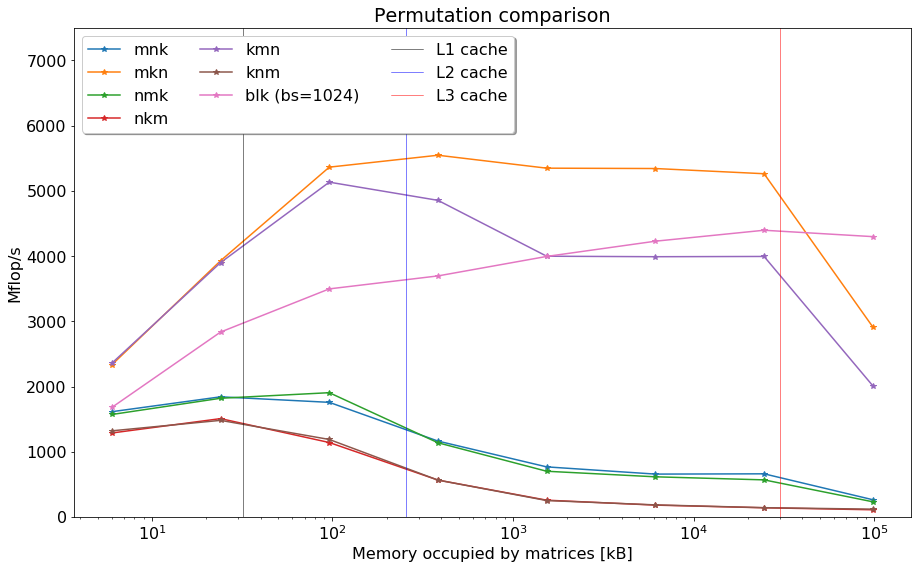

In [4]:
# megaflops when multiplying two square matrices in varying order
f, ax = plt.subplots(figsize=(15,9))

#ax.semilogx(lib['size'], lib['Mflop/s'], marker='*', label='lib');
ax.semilogx(mnk['size'], mnk['Mflop/s'], marker='*', label='mnk');
ax.semilogx(mkn['size'], mkn['Mflop/s'], marker='*', label='mkn');
ax.semilogx(nmk['size'], nmk['Mflop/s'], marker='*', label='nmk');
ax.semilogx(nkm['size'], nkm['Mflop/s'], marker='*', label='nkm');
ax.semilogx(kmn['size'], kmn['Mflop/s'], marker='*', label='kmn');
ax.semilogx(knm['size'], knm['Mflop/s'], marker='*', label='knm');
ax.semilogx(blk['size'], blk['Mflop/s'], marker='*', label='blk (bs=1024)');
ax.set(xlabel='Memory occupied by matrices [kB]', ylabel='Mflop/s', title='Permutation comparison',
      ylim=(0,7500));

#ax.axhline(max_mflops)
ax.axvline(32, linewidth=0.5, color='k', label='L1 cache')
ax.axvline(256, linewidth=0.5, color='b', label='L2 cache')
ax.axvline(30000, linewidth=0.5, color='r', label='L3 cache')
ax.legend(loc='upper left', bbox_to_anchor=(0.0, 1),
          ncol=3, fancybox=True, shadow=True);

# uncomment to save figure:
#f.savefig('plots/per_comparison.png', dpi=300)

In [5]:
# max clock freq. 2.9 GHz
clockmax = 2900 #MHz
# instructions per cycle
instr_p_cyc = 16
max_mflops = clockmax * instr_p_cyc
max_mflops # theoretically

46400

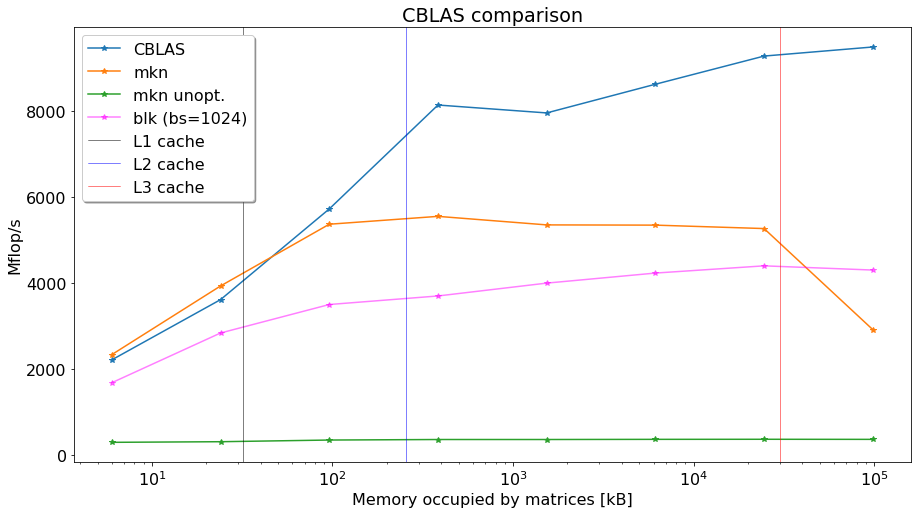

In [6]:
# unoptimized (native) mkn vs  optimized mkn vs CBLAS
f, ax = plt.subplots(figsize=(15,8))

ax.semilogx(lib['size'], lib['Mflop/s'], marker='*', label='CBLAS');
ax.semilogx(mkn['size'], mkn['Mflop/s'], marker='*', label='mkn');
ax.semilogx(unopt['size'], unopt['Mflop/s'], marker='*', label='mkn unopt.');
ax.semilogx(blk['size'], blk['Mflop/s'], marker='*', label='blk (bs=1024)', color='magenta', alpha=0.5);
ax.set(xlabel='Memory occupied by matrices [kB]', ylabel='Mflop/s', title='CBLAS comparison');

#ax.axhline(max_mflops, linestyle='--', label='Theoretical max', linewidth=0.8)
ax.axvline(32, linewidth=0.5, color='k', label='L1 cache')
ax.axvline(256, linewidth=0.5, color='b', label='L2 cache')
ax.axvline(30000, linewidth=0.5, color='r', label='L3 cache')
ax.legend(loc='upper left', bbox_to_anchor=(0.0, 1),
          ncol=1, fancybox=True, shadow=True);

# uncomment to save figure:
#f.savefig('plots/native_vs_cblas.png', dpi=300)

### Hardware stats

In [9]:
cache #hits and misses

,L1Hits,L1Misses,L2Hits,L2Misses,Versions
0,4854859430,854667273,829059263,26026029,blk
1,4924934139,35211015,28809010,4004007,lib
2,25605582566,9820671074,1049928329,8768768757,nkm
3,25605582560,9731043041,1145958360,8585585578,knm
4,15725711558,1075536329,560175172,514514516,nmk
5,17137121725,918687290,614592195,304304305,mnk
6,4664660462,649803203,473748148,178178179,kmn
7,4974970495,720225226,643401199,74074075,mkn


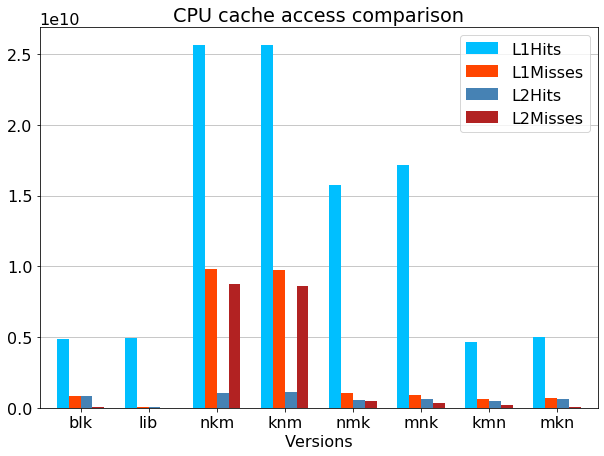

In [10]:
ax = cache.plot.bar(x='Versions', rot=0, color=['deepskyblue','orangered', 'steelblue', 'firebrick'],
               title='CPU cache access comparison', figsize=(10,7), width=0.7, zorder=3);
ax.yaxis.grid(True, color='#BBBBBB')

# uncomment to save figure:
#plt.savefig('plots/cache_access.png', dpi=300)

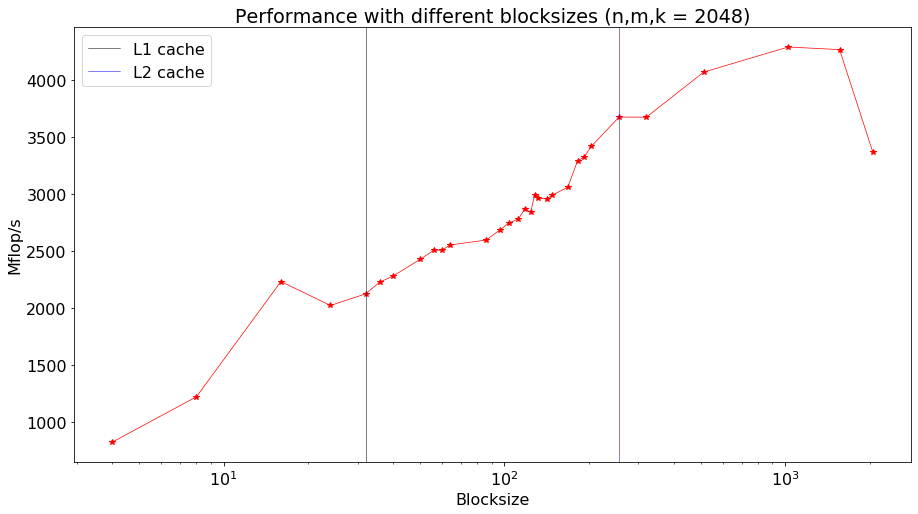

In [11]:
f, ax = plt.subplots(figsize=(15,8))
ax.semilogx(blksize['Blocksize'], blksize['Mflop/s'], marker='*', linewidth=0.7, color='r');
ax.set(xlabel='Blocksize', ylabel='Mflop/s', title='Performance with different blocksizes (n,m,k = 2048)');

ax.axvline(32, linewidth=0.5, color='k', label='L1 cache');
ax.axvline(256, linewidth=0.5, color='b', label='L2 cache');

ax.legend();

# uncomment to save figure:
f.savefig('plots/blocksize_comparison.png')

# 2. Poisson Problem

In [31]:
import numpy as np

In [70]:
threads = [1, 2, 4, 8, 12, 16, 20, 24]

p200 = pd.read_csv('data/p200.csv', names=['wallclock[s]','Mflop/s'])
p200.index = threads

p100 = pd.read_csv('data/p100.csv', names=['wallclock[s]','Mflop/s'])
p100.index = threads

p50 = pd.read_csv('data/p50.csv', names=['wallclock[s]','Mflop/s'])
p50.index = threads

p10 = pd.read_csv('data/p10.csv', names=['wallclock[s]','Mflop/s'])
p10.index = threads

gs100 = pd.read_csv('data/gs100.csv', names=['wallclock[s]','Mflop/s'])
gs100.index = threads

In [58]:
p100b = p100['Mflop/s'][1] #baseline
p100th = p100b*np.asarray(threads) # (theoretical) perfect scaling

p50b = p50['Mflop/s'][1] #baseline
p50th = p50b*np.asarray(threads) # (theoretical) perfect scaling

gs1base = gs100['Mflop/s'][1]
gs1theor = gs1base*np.asarray(threads)

array([ 2343.89582,  4687.79164,  9375.58328, 18751.16656, 28126.74984,
       37502.33312, 46877.9164 , 56253.49968])

## Performance characteristics when scaling to multiple cores

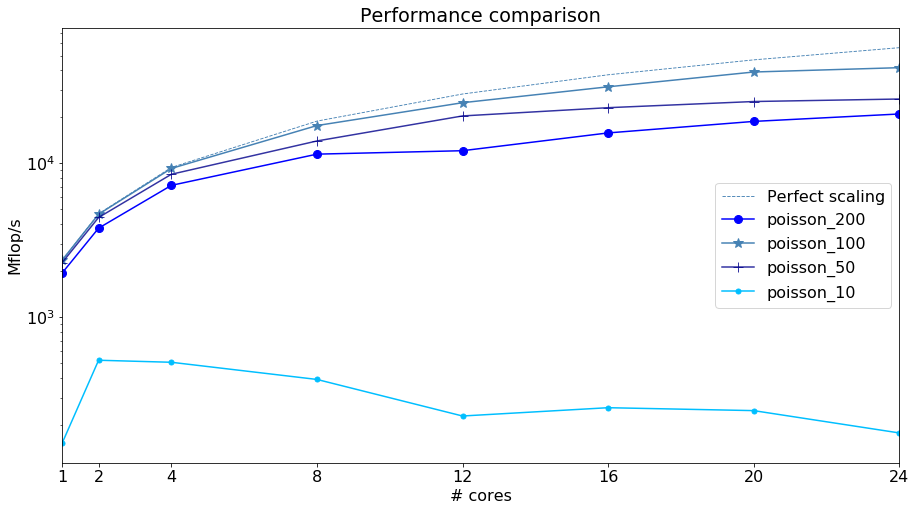

In [80]:
f, ax = plt.subplots(figsize=(15,8))

# poisson
# perfect scaling
ax.semilogy(threads, p100th, label = 'Perfect scaling', linestyle='--', linewidth=0.9, color='steelblue')
# N = 200
ax.semilogy(p200['Mflop/s'], marker='o', markersize=8, label='poisson_200', color='b');
# N = 100
ax.semilogy(p100['Mflop/s'], marker='*', markersize=10, label='poisson_100', color='steelblue');
#ax.semilogy(threads, p100th, label = 'Perfect scaling', linestyle='--', linewidth=0.9, color='steelblue')
# N = 50
ax.semilogy(p50['Mflop/s'], marker='+', markersize=10, label='poisson_50', color='darkblue', alpha=0.8);
#ax.semilogy(threads, p50th, label = 'Perfect scaling', linestyle='--', linewidth=0.9, color='darkblue')
ax.semilogy(p10['Mflop/s'], marker='.', markersize=10, label='poisson_10', color='deepskyblue');


ax.set(xlabel="# cores", ylabel='Mflop/s', title='Performance comparison', 
       xlim=(1,24), xticks=threads);
ax.legend();

#f.savefig('poisson_gs_comp.png', dpi=300)

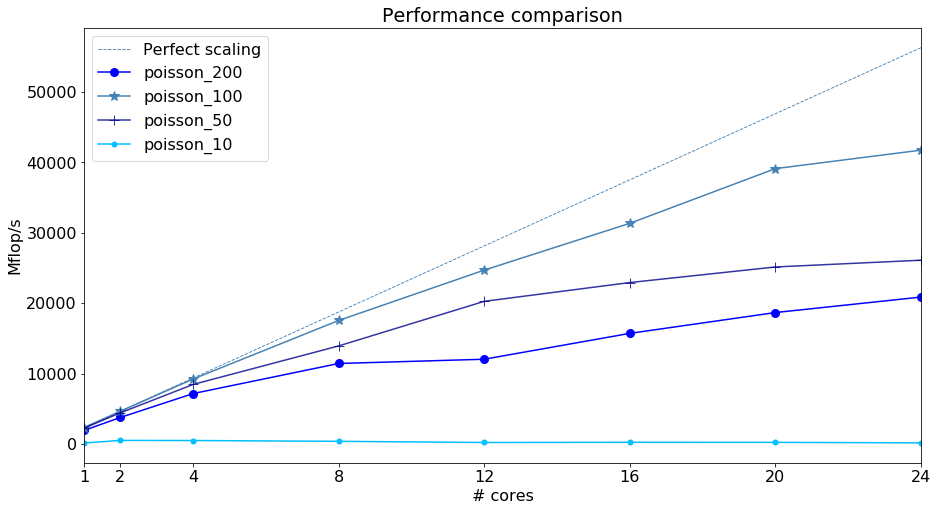

In [78]:
f, ax = plt.subplots(figsize=(15,8))

# poisson
# perfect scaling
ax.plot(threads, p100th, label = 'Perfect scaling', linestyle='--', linewidth=0.9, color='steelblue')
# N = 200
ax.plot(p200['Mflop/s'], marker='o', markersize=8, label='poisson_200', color='b');
# N = 100
ax.plot(p100['Mflop/s'], marker='*', markersize=10, label='poisson_100', color='steelblue');
#ax.plot(threads, p100th, label = 'Perfect scaling', linestyle='--', linewidth=0.9, color='steelblue')
# N = 50
ax.plot(p50['Mflop/s'], marker='+', markersize=10, label='poisson_50', color='darkblue', alpha=0.8);
#ax.plot(threads, p50th, label = 'Perfect scaling', linestyle='--', linewidth=0.9, color='darkblue')
ax.plot(p10['Mflop/s'], marker='.', markersize=10, label='poisson_10', color='deepskyblue');

# gauss-seidel
# N = 100
#ax.plot(gs100['Mflop/s'], marker='o', markersize=8, label='gauss-seidel_100', color='orange');
#ax.plot(threads, gs1theor, label = 'Perfect scaling', linestyle='--', linewidth=0.9, color='orange')


ax.set(xlabel="# cores", ylabel='Mflop/s', title='Performance comparison', 
       xlim=(1,24), xticks=threads);
ax.legend();

#f.savefig('poisson_gs_comp.png', dpi=300)

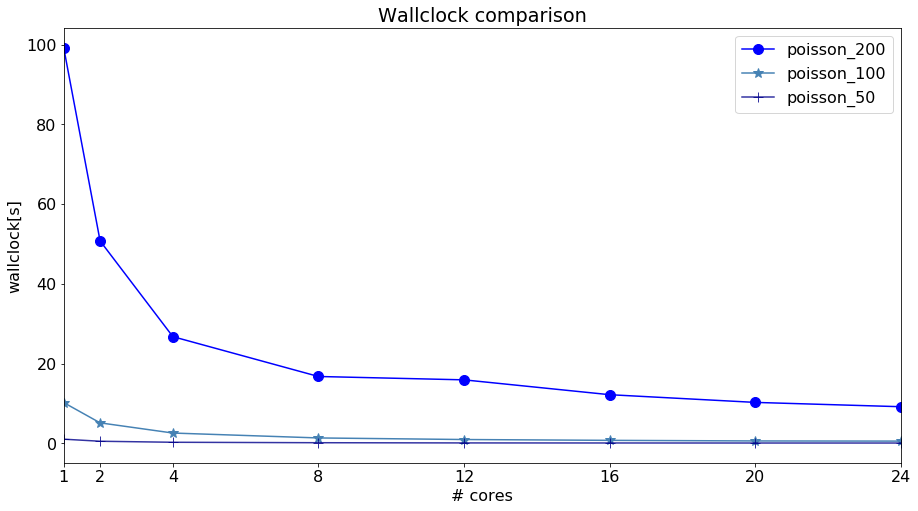

In [69]:
f, ax = plt.subplots(figsize=(15,8))

# poisson
# N = 200
ax.plot(p200['wallclock[s]'], marker='o', markersize=10, label='poisson_200', color='b');
#ax.plot(threads, p100th, label = 'Perfect scaling', linestyle='--', linewidth=0.9, color='steelblue')
# N = 100
ax.plot(p100['wallclock[s]'], marker='*', markersize=10, label='poisson_100', color='steelblue');
#ax.plot(threads, p100th, label = 'Perfect scaling', linestyle='--', linewidth=0.9, color='steelblue')
# N = 50
ax.plot(p50['wallclock[s]'], marker='+', markersize=10, label='poisson_50', color='darkblue', alpha=0.8);
#ax.plot(threads, p50th, label = 'Perfect scaling', linestyle='--', linewidth=0.9, color='darkblue')

# gauss-seidel
# N = 100
#ax.plot(gs100['wallclock[s]'], marker='o', markersize=8, label='gauss-seidel_100', color='orange');
#ax.plot(threads, gs1theor, label = 'Perfect scaling', linestyle='--', linewidth=0.9, color='orange')


ax.set(xlabel="# cores", ylabel='wallclock[s]', title='Wallclock comparison', 
       xlim=(1,24), xticks=threads);
ax.legend();

#f.savefig('poisson_gs_comp.png', dpi=300)

In [87]:
df = pd.concat([p10, p50, p100, p200])
df

,wallclock[s],Mflop/s
1,0.00735,151.81277
2,0.00213,523.93589
4,0.00220,508.23488
8,0.00284,393.11693
12,0.00491,227.47938
16,0.00433,257.55713
20,0.00453,246.58080
24,0.00632,176.60894
1,1.05943,2259.69526
2,0.53974,4435.49370


In [93]:
df.drop(columns=['wallclock[s]'], inplace=True)
df

,Mflop/s
1,151.81277
2,523.93589
4,508.23488
8,393.11693
12,227.47938
16,257.55713
20,246.58080
24,176.60894
1,2259.69526
2,4435.49370
